In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from core.config import *

from core.datasets import VOC2012SegDataset
from core.data import crop_augment_preprocess_batch
from core.color_map import apply_colormap
from core.viz import get_layer_numel_str

from torchvision.models import segmentation as segmodels
from torchvision.transforms._presets import SemanticSegmentation

import torchvision.transforms.v2 as T
from segmentation_models_pytorch.encoders import get_preprocessing_fn
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp

from collections import OrderedDict
from functools import partial


# DeepLabV3_ResNet50 (from PyTorch)

In [ ]:
_model_name = 'deeplabv3_resnet50'
model = segmodels.deeplabv3_resnet50(
    weights=None,
    weight_backbone=None,
    aux_loss=True
).to('cuda')
resize_size = 520
preprocess_fn = partial(SemanticSegmentation, resize_size=resize_size)()

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /home/olivieri/exp/data/private/torch_weights/checkpoints/mobilenet_v3_large-8738ca79.pth


100%|██████████| 21.1M/21.1M [00:00<00:00, 102MB/s]


In [ ]:
for m in model.named_children():
    print(m[0])

# DeepLabV3_ResNet18 (from SMP)

In [ ]:
model = smp.DeepLabV3(
    encoder_name="resnet18", # the paper uses ResNet-101 as the backbone network.
    encoder_weights=None, # the encoder is pre-trained on ImageNet.
    encoder_output_stride=8, # the paper advocates for an output stride of 8 for denser feature maps and better performance.
    decoder_channels=256, # the ASPP module uses 256 filters for its convolutions.
    decoder_atrous_rates=(12, 24, 36), # for an output stride of 8, the atrous rates are doubled to (12, 24, 36).
    classes=21, # VOC2012 classes
    # The upsampling factor should match the output stride. Setting it to None allows the
    # model to infer this automatically, which is consistent with the paper's method of
    # upsampling the final logits by a factor of 8.
    upsampling=None
).to('cuda')

_model_name = 'deeplabv3_resnet18'
resize_size = 520 # no specified resize_size for this model
_preprocess_fn = get_preprocessing_fn('resnet18', pretrained='imagenet') # for PIL images
preprocess_fn = partial(SemanticSegmentation, resize_size=resize_size)()

In [17]:
for m in model.named_children():
    print(m[0])

encoder
decoder
segmentation_head


---

In [ ]:
# save_weights_root_path = Path(f'/home/olivieri/exp/data/private/torch_weights/seg/{_model_name}')
# ckp_filename = Path(f'{_model_name}-enc-pt.pth')
# full_ckp_path = save_weights_root_path / ckp_filename
# torch.save(model.state_dict(), full_ckp_path)

In [ ]:
state_dict: OrderedDict = torch.load(f'/home/olivieri/exp/data/private/torch_weights/seg/{_model_name}/{_model_name}-enc-pt.pth')
model_state_dict = state_dict.get('model_state_dict', state_dict)
model.load_state_dict(model_state_dict)

<All keys matched successfully>

In [11]:
val_ds = VOC2012SegDataset(
    root_path=Path(BASE_CONFIG['datasets']['VOC2012_root_path']),
    split='val',
    device=BASE_CONFIG['device'],
    resize_size=resize_size,
    center_crop=False,
    with_unlabelled=True,
)

In [12]:
collate_fn = partial(
    crop_augment_preprocess_batch,
    crop_fn=T.CenterCrop(resize_size),
    augment_fn=None,
    preprocess_fn=preprocess_fn
)

In [13]:
val_dl = DataLoader(
    val_ds,
    batch_size=8,
    shuffle=False,
    generator=get_torch_gen(),
    collate_fn=collate_fn,
)

In [14]:
for scs, gts in val_dl:
    scs = scs.to(BASE_CONFIG['device'])
    gts = gts.to(BASE_CONFIG['device'])

    logits = model(scs)
    logits = logits["out"] if isinstance(logits, OrderedDict) else logits # [B, C, H, W]
    
    break
logits.shape

torch.Size([8, 21, 520, 520])

In [12]:
mask = apply_colormap(logits.argmax(dim=1, keepdim=True), val_ds.get_color_map_dict())

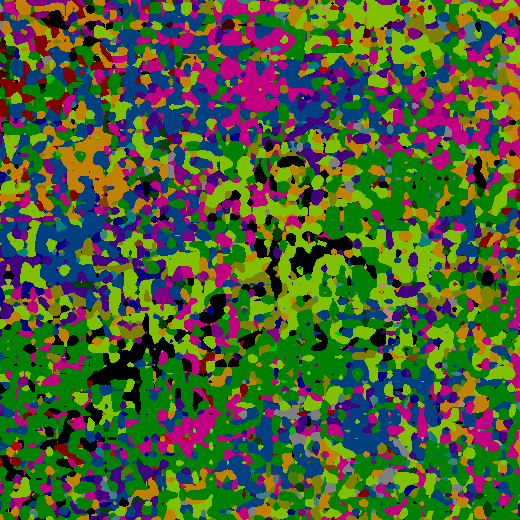

In [13]:
to_pil_image(mask[0])